In [54]:
%matplotlib inline
import numpy as np
import torch as t
import time
from torch import nn,optim
import math
import sys
sys.path.append('..')
import d2l_2 as d2l

# 一维梯度下降

In [2]:
def f(x):
    return x**2

def gradf(x):
    return 2*x

def gd(eta):
    x=10
    results=[x]
    for i in range(10):
        x-=eta*gradf(x)
        results.append(x)
    print('epoch 10,x:',x)
    return results

res=gd(0.2)

epoch 10,x: 0.06046617599999997


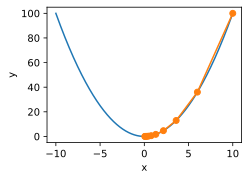

In [12]:
def show_trace(res):
    n=max(abs(min(res)),abs(max(res)))
    f_line=np.arange(-n,n,0.01)
    d2l.set_figsize((3.5,2.5))
    d2l.plt.plot(f_line,f(f_line))
    d2l.plt.plot(res,f(np.array(res)),'-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('y')

show_trace(res)

### 学习率

epoch 10,x: 3.4867844009999995


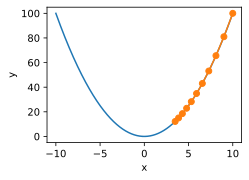

In [14]:
show_trace(gd(0.05))#eta 0.2->0.05

epoch 10,x: 61.917364224000096


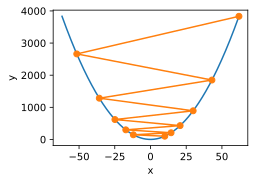

In [15]:
show_trace(gd(1.1))

### 局部极小值

epoch 10,x: -1.5281659276350823


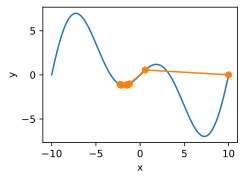

In [16]:
c=0.15*np.pi

def f(x):
    return x*np.cos(c*x)

def gradf(x):
    return np.cos(c*x)-c*x*np.sin(c*x)

show_trace(gd(2))

## 多维梯度下降

In [48]:
def train_2d(trainer,steps=20):
    x1,x2=-5,-2
    results=[(x1,x2)]
    for i in range(steps):
        x1,x2=trainer(x1,x2)
        results.append((x1,x2))
    print('epoch %d, x1 %f, x2 %f'%(i+1,x1,x2))
    return results

def show_trace_2d(f,results):
    d2l.plt.plot(*zip(*results),'-o',color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1,x2,f(x1,x2),colors='#1f77b4')#等高线
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')
    print('f(x1,x2):',f(results[-1][0],results[-1][1]))

epoch 20, x1 -0.057646, x2 -0.000073
f(x1,x2): 0.0033230806834579213


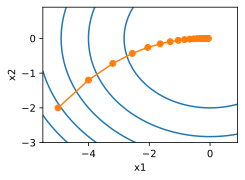

In [49]:
eta=0.1

def f_2d(x1,x2):
    return x1**2+2*x2**2

def gd_2d(x1,x2):
    return (2*x1,4*x2)

def trainer_2d(x1,x2):
    gd_x1,gd_x2=gd_2d(x1,x2)
    return (x1-eta*gd_x1,x2-eta*gd_x2)

show_trace_2d(f_2d,train_2d(trainer_2d))

In [21]:
#*zip(*results)使results中的x1,x2一一对应

## 自适应方法

### 牛顿法

epoch 10, x: 0.0


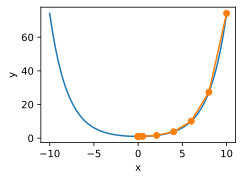

In [23]:
c=0.5

def f(x):
    return np.cosh(c*x)

def gradf(x):
    return c*np.sinh(c*x)

def hessf(x):
    return c**2*np.cosh(c*x)#Hessian(二阶导数)

def newton(eta=1):
    x=10
    results=[x]
    for i in range(10):
        x-=eta*gradf(x)/hessf(x)
        results.append(x)
    print('epoch 10, x:',x)
    return results

show_trace(newton())

epoch 10, x: 26.83413291324767


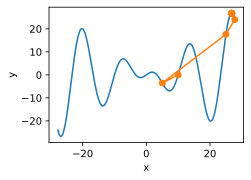

In [24]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

def hessf(x):
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

show_trace(newton())

epoch 10, x: 7.269860168684531


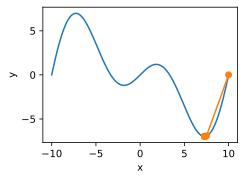

In [25]:
show_trace(newton(0.5))

# 随机梯度下降

## 随机梯度下降参数更新

epoch 50, x1 -0.133666, x2 0.179764
f(x1,x2): 0.08249709735156123


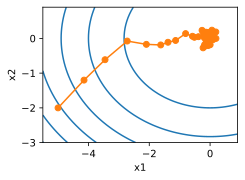

In [50]:
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2  

def gradf(x1, x2):
    return (2 * x1, 4 * x2)

def sgd(x1,x2):
    global lr
    (g1,g2)=gradf(x1,x2)
    (g1,g2)=(g1+np.random.normal(0.1),g2+np.random.normal(0.1))#均值0.1
    eta_t=eta*lr() # Learning rate at time t
    return (x1-eta_t*g1,x2-eta_t*g2)

eta=0.1
lr=(lambda: 1)# Constant learning rate
show_trace_2d(f,train_2d(sgd,steps=50))

In [31]:
np.random.normal??

In [38]:
lr()

1

## 动态学习率

epoch 1000, x1 -0.888817, x2 -0.124298
f(x1,x2): 0.8208956032008604


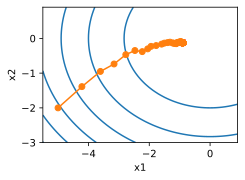

In [51]:
def exponential():
    global ctr
    ctr+=1
    return math.exp(-0.1*ctr)

ctr=1
lr=exponential
show_trace_2d(f,train_2d(sgd,steps=1000))

epoch 50, x1 0.141600, x2 -0.053114
f(x1,x2): 0.02569291476537927


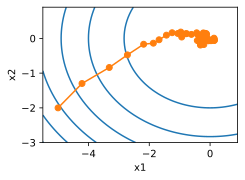

In [52]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr=1
lr=polynomial
show_trace_2d(f,train_2d(sgd,steps=50))

# 小批量随机梯度下降

## 读取数据

In [57]:
def get_data_ch7():#本函数已保存在d2l_2中
    data=np.genfromtxt('airfoil_self_noise.dat',delimiter='\t')
    data=(data-data.mean(axis=0))/data.std(axis=0)#标准化
    return t.tensor(data[:1500,:-1],dtype=t.float32),t.tensor(data[:1500,-1],dtype=t.float32)

features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [58]:
import pandas as pd
df=pd.read_csv('airfoil_self_noise.dat', delimiter='\t',header=None)
df.head(10)

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
5,2500,0.0,0.3048,71.3,0.002663,125.571
6,3150,0.0,0.3048,71.3,0.002663,125.201
7,4000,0.0,0.3048,71.3,0.002663,123.061
8,5000,0.0,0.3048,71.3,0.002663,121.301
9,6300,0.0,0.3048,71.3,0.002663,119.541


## 从零开始实现

In [59]:
def sgd(params,states,hyperparams):
    for p in params:
        p.data-=hyperparams['lr']*p.grad.data

In [64]:
#本函数已保存在d2l_2中
def train_ch7(optimizer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
    #初始化模型
    net,loss=d2l.linreg,d2l.squared_loss
    
    w=nn.Parameter(t.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)),dtype=t.float32))
    b = nn.Parameter(t.zeros((1,1), dtype=t.float32))
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()
    
    ls=[eval_loss()]
    dataset=t.utils.data.TensorDataset(features, labels)
    data_iter=t.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X,w,b),y).mean()# 使用平均损失
            
            #梯度清零
            if w.grad is not None:#第一次更新前无需清零（None）
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w,b],states,hyperparams)  # 迭代模型参数
            if (batch_i+1)*batch_size%100==0:
                ls.append(eval_loss())#每100个样本记录下当前训练误差
    #打印结果和作图
    print('loss: %f, %f sec per epoch'%(ls[-1],time.time()-start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

In [65]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

loss: 0.246077, 0.099006 sec per epoch


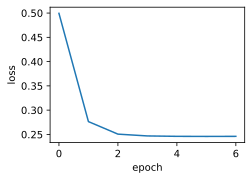

In [66]:
train_sgd(1,1500,6)

loss: 0.242723, 2.158123 sec per epoch


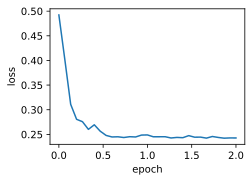

In [69]:
train_sgd(0.005,1,2)

loss: 0.278229, 1.558089 sec per epoch


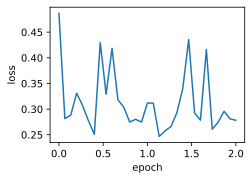

In [77]:
train_sgd(0.05,1,2)#学习率太大会不收敛

loss: 0.244746, 0.326019 sec per epoch


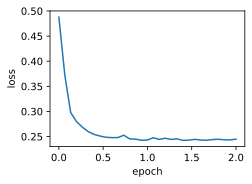

In [74]:
train_sgd(0.05,10)

## 简洁实现

In [79]:
# 本函数与原书不同的是这里第一个参数优化器函数而不是优化器的名字
# 例如: optimizer_fn=optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn,optimizer_hyperparams,features,labels,batch_size=10,num_epochs=2):
    #初始化模型
    net=nn.Linear(features.shape[-1],1)
    loss=nn.MSELoss()
    optimizer=optimizer_fn(net.parameters(),**optimizer_hyperparams)
    
    def eval_loss():
        return loss(net(features).view(-1),labels).item()/2#MSELoss中未/2
    
    ls=[eval_loss()]
    dataset=t.utils.data.TensorDataset(features, labels)
    data_iter=t.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.242676, 0.468027 sec per epoch


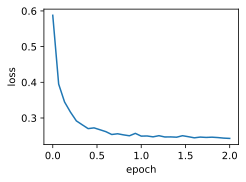

In [80]:
train_pytorch_ch7(optim.SGD,{'lr':0.05},features,labels)